#### evaluate bias and std in the TAC images

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import scipy.ndimage

In [2]:
import sys
sys.path.append('../../Preprocess/')
import BiasCorrection as BC

In [3]:
# load ROIs
biasROIs = np.load('/home/dwu/trainData/Noise2Noise/train/ctp/real/evals/rois/bias.npy', allow_pickle=True)
stdROIs = np.load('/home/dwu/trainData/Noise2Noise/train/ctp/real/evals/rois/bias.npy', allow_pickle=True)

In [4]:
# load original images for bias correction
imgDir = '/home/dwu/trainData/Noise2Noise/train/ctp/real/data/'
imgNorm = 0.15
nTest = 5
imgs = np.load(os.path.join(imgDir, 'imgs4d.npy'), allow_pickle=True)[-nTest:] / 1000 / imgNorm
masks = np.load(os.path.join(imgDir, 'mask.npy'), allow_pickle=True)[-nTest:]

In [5]:
for i in range(len(imgs)):
    maskVessel = np.where(np.max(imgs[i], -1) > 0.1 / imgNorm, 1, 0)[...,np.newaxis]
    maskVessel *= masks[i]
    for k in range(maskVessel.shape[0]):
        maskVessel[k,...,0] = scipy.ndimage.morphology.binary_dilation(maskVessel[k,...,0])
    masks[i] *= (1 - maskVessel)

for i in range(len(imgs)):
    imgs[i] *= masks[i]
    
tacs = []
for i in range(len(imgs)):
    tacs.append(imgs[i] - (imgs[i][...,[0]] + imgs[i][...,[1]]) / 2)

In [6]:
for i in range(len(masks)):
    biasROIs[i] *= masks[i]
    stdROIs[i] *= masks[i]

In [7]:
def GetROIMeanStd(imgs, biasROIs, stdROIs):
    means = []
    stds = []
    for i in range(len(imgs)):           
        if biasROIs[i].sum() > 0:
            means.append(np.sum(imgs[i] * biasROIs[i], (0,1,2)) / np.sum(biasROIs[i], (0,1,2)))

        if stdROIs[i].sum() > 0:
            m = np.sum(imgs[i] * stdROIs[i], (0,1,2)) / np.sum(stdROIs[i], (0,1,2))
            var = np.sum((imgs[i] - m)**2 * stdROIs[i], (0,1,2)) / np.sum(stdROIs[i], (0,1,2))
            stds.append(np.sqrt(var))
    
    return np.concatenate(means), np.concatenate(stds)

In [8]:
# bias and std of original images
originMeans, originStds = GetROIMeanStd(tacs, biasROIs, stdROIs)

In [9]:
# bias and std of gaussian
gaussBiases = []
gaussStds = []
guassSigmas = []
filenames = glob.glob('/home/dwu/trainData/Noise2Noise/train/ctp/real/gaussian/Gaussian_*.npy')
for filename in filenames:
    print (filename)
    tokens = os.path.basename(filename).strip('.npy').split('_')
    if len(tokens) < 3:
        continue
    
    guassSigmas.append(float(tokens[-1]))
    res = np.load(filename, allow_pickle=True)
    for i in range(len(res)):
        res[i] = res[i] * masks[i]
    m, s = GetROIMeanStd(res, biasROIs, stdROIs)
    
    gaussBiases.append(np.mean(np.abs(m - originMeans)))
    gaussStds.append(np.mean(s))

inds = np.argsort(guassSigmas)
guassSigmas = np.array(guassSigmas)[inds]
gaussBiases = np.array(gaussBiases)[inds]
gaussStds = np.array(gaussStds)[inds]

/home/dwu/trainData/Noise2Noise/train/ctp/real/gaussian/Gaussian_std_1.npy
/home/dwu/trainData/Noise2Noise/train/ctp/real/gaussian/Gaussian_std_2.npy
/home/dwu/trainData/Noise2Noise/train/ctp/real/gaussian/Gaussian_std_3.npy
/home/dwu/trainData/Noise2Noise/train/ctp/real/gaussian/Gaussian_std_4.npy
/home/dwu/trainData/Noise2Noise/train/ctp/real/gaussian/Gaussian_std_0.npy


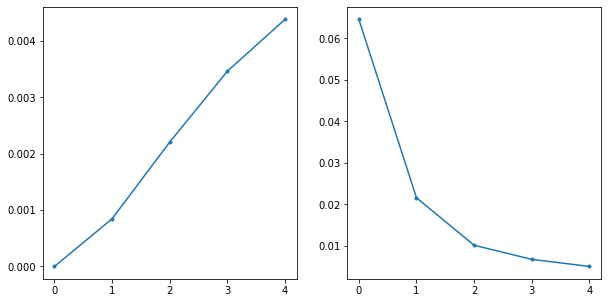

In [10]:
plt.figure(figsize=[10,5])
plt.subplot(121); plt.plot(guassSigmas, gaussBiases, '.-')
plt.subplot(122); plt.plot(guassSigmas, gaussStds, '.-')

In [11]:
# bias and std of TIPS
tipsBiases = {}
tipsStds = {}
tipsSigmas = {}
filenames = glob.glob('/home/dwu/trainData/Noise2Noise/train/ctp/real/tips/TIPS*.npy')
for filename in filenames:
    print (filename)
    tokens = os.path.basename(filename).strip('.npy').split('_')
    
    sigma1 = float(tokens[2])
    sigma2 = float(tokens[3])
    
    res = np.load(filename, allow_pickle=True)
    for i in range(len(res)):
        res[i] = res[i] * masks[i]
    m, s = GetROIMeanStd(res, biasROIs, stdROIs)
    
    if sigma1 not in tipsSigmas:
        tipsBiases[sigma1] = []
        tipsStds[sigma1] = []
        tipsSigmas[sigma1] = []
        
    tipsBiases[sigma1].append(np.mean(np.abs(m - originMeans)))
    tipsStds[sigma1].append(np.mean(s))
    tipsSigmas[sigma1].append(sigma2)

for sigma in tipsSigmas:
    inds = np.argsort(tipsSigmas[sigma])
    tipsSigmas[sigma] = np.array(tipsSigmas[sigma])[inds]
    tipsBiases[sigma] = np.array(tipsBiases[sigma])[inds]
    tipsStds[sigma] = np.array(tipsStds[sigma])[inds]

/home/dwu/trainData/Noise2Noise/train/ctp/real/tips/TIPS_sigma_0.075_1.npy
/home/dwu/trainData/Noise2Noise/train/ctp/real/tips/TIPS_sigma_0.05_1.npy
/home/dwu/trainData/Noise2Noise/train/ctp/real/tips/TIPS_sigma_0.025_1.npy
/home/dwu/trainData/Noise2Noise/train/ctp/real/tips/TIPS_sigma_0.1_1.npy
/home/dwu/trainData/Noise2Noise/train/ctp/real/tips/TIPS_sigma_0.025_2.npy
/home/dwu/trainData/Noise2Noise/train/ctp/real/tips/TIPS_sigma_0.1_2.npy
/home/dwu/trainData/Noise2Noise/train/ctp/real/tips/TIPS_sigma_0.05_2.npy
/home/dwu/trainData/Noise2Noise/train/ctp/real/tips/TIPS_sigma_0.075_2.npy
/home/dwu/trainData/Noise2Noise/train/ctp/real/tips/TIPS_sigma_0.05_3.npy
/home/dwu/trainData/Noise2Noise/train/ctp/real/tips/TIPS_sigma_0.075_3.npy
/home/dwu/trainData/Noise2Noise/train/ctp/real/tips/TIPS_sigma_0.025_3.npy
/home/dwu/trainData/Noise2Noise/train/ctp/real/tips/TIPS_sigma_0.1_3.npy
/home/dwu/trainData/Noise2Noise/train/ctp/real/tips/TIPS_sigma_0.1_4.npy
/home/dwu/trainData/Noise2Noise/trai

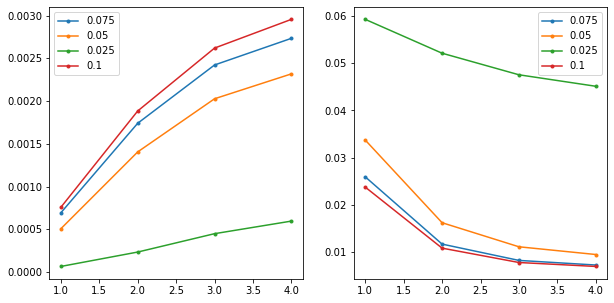

In [12]:
plt.figure(figsize=[10,5])
plt.subplot(121)
for sigma in tipsSigmas:
    plt.plot(tipsSigmas[sigma], tipsBiases[sigma], '.-')
plt.legend([k for k in tipsSigmas])

plt.subplot(122)
for sigma in tipsSigmas:
    plt.plot(tipsSigmas[sigma], tipsStds[sigma], '.-')
plt.legend([k for k in tipsSigmas])

In [13]:
# bias and std of Noise2Noise
n2nBiases = []
n2nStds = []
n2nBetas = []
dirnames = glob.glob('/home/dwu/trainData/Noise2Noise/train/ctp/real/beta_*')
for dirname in dirnames:
    print (dirname)
    tokens = os.path.basename(dirname).split('_')
    n2nBetas.append(float(tokens[-1]))
    
    res = np.load(os.path.join(dirname, 'tmp', 'iodines.npy'), allow_pickle=True)[-nTest:]
    for i in range(len(res)):
        res[i] = res[i] * 0.025 / imgNorm
        # bias correction
        res[i] = BC.BiasCorrection(res[i], tacs[i], masks[i])
    
    m, s = GetROIMeanStd(res, biasROIs, stdROIs)
    
    n2nBiases.append(np.mean(np.abs(m - originMeans)))
    n2nStds.append(np.mean(s))

inds = np.argsort(n2nBetas)
n2nBetas = np.array(n2nBetas)[inds]
n2nBiases = np.array(n2nBiases)[inds]
n2nStds = np.array(n2nStds)[inds]

/home/dwu/trainData/Noise2Noise/train/ctp/real/beta_0
/home/dwu/trainData/Noise2Noise/train/ctp/real/beta_50
/home/dwu/trainData/Noise2Noise/train/ctp/real/beta_25
/home/dwu/trainData/Noise2Noise/train/ctp/real/beta_12.5
/home/dwu/trainData/Noise2Noise/train/ctp/real/beta_37.5


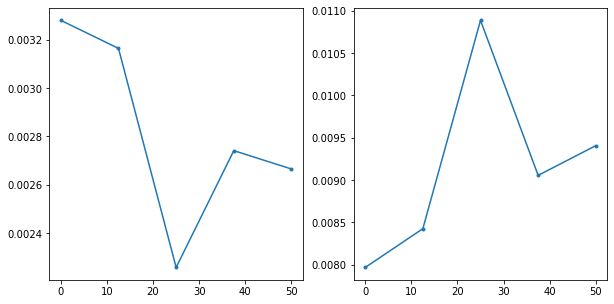

In [14]:
plt.figure(figsize=[10,5])
plt.subplot(121); plt.plot(n2nBetas, n2nBiases, '.-')
plt.subplot(122); plt.plot(n2nBetas, n2nStds, '.-')

In [15]:
# bias and std of supervised learning
supBiases = []
supStds = []
supBetas = []
filenames = glob.glob('/home/dwu/trainData/Noise2Noise/train/ctp/real/supervised/supervised*.npy')
for filename in filenames:
    print (filename)
    tokens = os.path.basename(filename).strip('.npy').split('_')
    if len(tokens) < 3:
        continue
    supBetas.append(float(tokens[-1]))
    
    res = np.load(filename, allow_pickle=True)
    for i in range(len(res)):
        res[i] = res[i] * 0.025 / imgNorm
        # bias correction
        res[i] = BC.BiasCorrection(res[i], tacs[i], masks[i])
    
    m, s = GetROIMeanStd(res, biasROIs, stdROIs)
    
    supBiases.append(np.mean(np.abs(m - originMeans)))
    supStds.append(np.mean(s))

inds = np.argsort(supBetas)
supBetas = np.array(supBetas)[inds]
supBiases = np.array(supBiases)[inds]
supStds = np.array(supStds)[inds]

/home/dwu/trainData/Noise2Noise/train/ctp/real/supervised/supervised_beta_0.npy
/home/dwu/trainData/Noise2Noise/train/ctp/real/supervised/supervised_beta_12.5.npy
/home/dwu/trainData/Noise2Noise/train/ctp/real/supervised/supervised_beta_25.npy
/home/dwu/trainData/Noise2Noise/train/ctp/real/supervised/supervised_beta_37.5.npy
/home/dwu/trainData/Noise2Noise/train/ctp/real/supervised/supervised_beta_50.npy


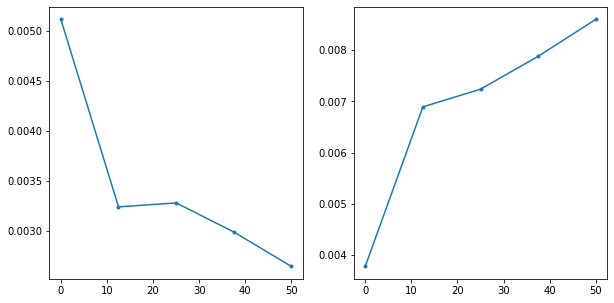

In [16]:
plt.figure(figsize=[10,5])
plt.subplot(121); plt.plot(supBetas, supBiases, '.-')
plt.subplot(122); plt.plot(supBetas, supStds, '.-')

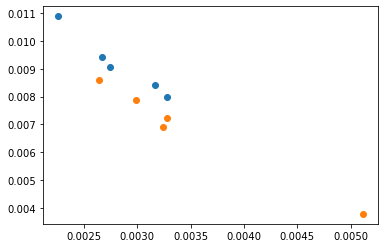

In [17]:
plt.plot(n2nBiases, n2nStds, 'o')
plt.plot(supBiases, supStds, 'o')
# plt.plot(gaussianBiases, gaussianStds, 'o')

In [18]:
gau = np.load('/home/dwu/trainData/Noise2Noise/train/ctp/real/gaussian/Gaussian_std_2.npy', allow_pickle=True)
tips = np.load('/home/dwu/trainData/Noise2Noise/train/ctp/real/tips/TIPS_sigma_0.075_2.npy', allow_pickle=True)
n2n = np.load('/home/dwu/trainData/Noise2Noise/train/ctp/real/beta_25/tmp/iodines.npy', allow_pickle=True)[-nTest:] * 0.025 / imgNorm
n2c = np.load('/home/dwu/trainData/Noise2Noise/train/ctp/real/supervised/supervised_beta_25.npy', allow_pickle=True)[-nTest:] * 0.025 / imgNorm

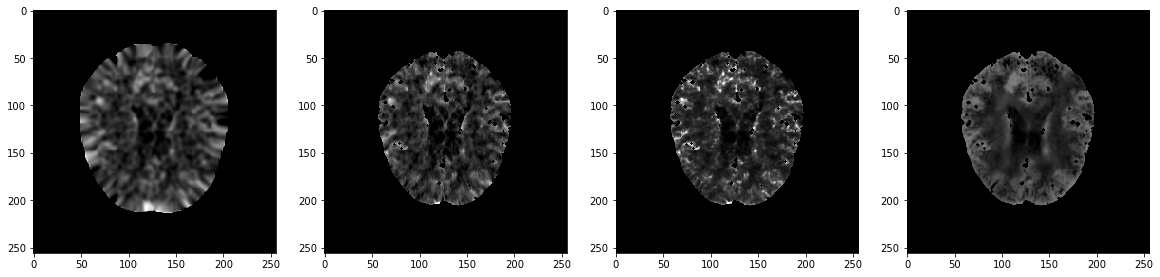

In [19]:
plt.figure(figsize=[20,5])
plt.subplot(141); plt.imshow(gau[2][7, ..., 20], 'gray', vmin=0, vmax=0.2)
plt.subplot(142); plt.imshow(tips[2][7, ..., 20], 'gray', vmin=0, vmax=0.2)
plt.subplot(143); plt.imshow(n2n[2][7, ..., 20], 'gray', vmin=0, vmax=0.2)
plt.subplot(144); plt.imshow(n2c[2][7, ..., 20], 'gray', vmin=0, vmax=0.2)

In [20]:
aifs = np.load(os.path.join(imgDir, 'aif.npy'), allow_pickle=True)[-nTest:] / 1000 / imgNorm
vofs = np.load(os.path.join(imgDir, 'vof.npy'), allow_pickle=True)[-nTest:] / 1000 / imgNorm
cbfFacs = np.load(os.path.join(imgDir, 'cbfFac.npy'), allow_pickle=True)[-nTest:]

In [21]:
import CalcParaMaps

In [22]:
bc2 = BC.BiasCorrection(n2n[2], tacs[2], masks[2])
cbfN2n, cbvN2n, mttN2n = CalcParaMaps.CalcParaMaps(bc2, masks[2], vof = vofs[2], aif = aifs[2])
cbfN2n *= cbfFacs[2]
mttN2n /= cbfFacs[2]

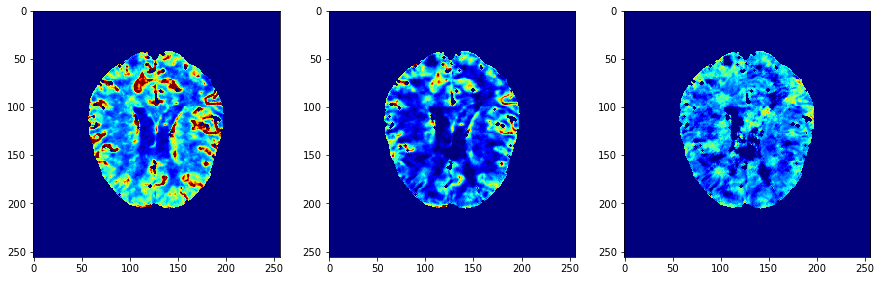

In [23]:
plt.figure(figsize=[15,5])
plt.subplot(131); plt.imshow(cbfN2n[7,...] * masks[2][7,...,0], 'jet', vmin=0, vmax=300)
plt.subplot(132); plt.imshow(cbvN2n[7,...] * masks[2][7,...,0], 'jet', vmin=0, vmax=5)
plt.subplot(133); plt.imshow(mttN2n[7,...] * masks[2][7,...,0], 'jet', vmin=0, vmax=2)

In [24]:
cbfTips, cbvTips, mttTips = CalcParaMaps.CalcParaMaps(tips[2], masks[2], vof = vofs[2], aif = aifs[2])
cbfTips *= cbfFacs[2]
mttTips /= cbfFacs[2]

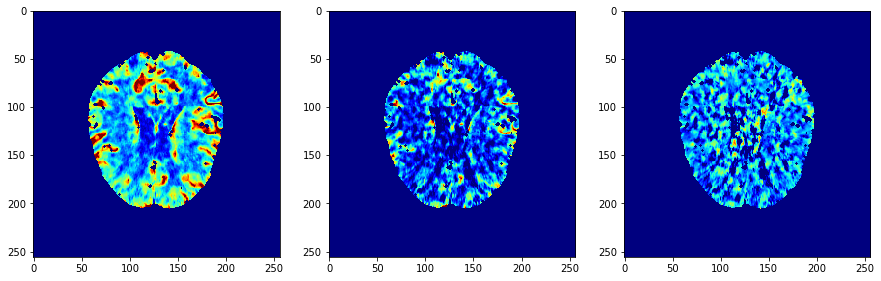

In [25]:
plt.figure(figsize=[15,5])
plt.subplot(131); plt.imshow(cbfTips[7,...] * masks[2][7,...,0], 'jet', vmin=0, vmax=300)
plt.subplot(132); plt.imshow(cbvTips[7,...] * masks[2][7,...,0], 'jet', vmin=0, vmax=5)
plt.subplot(133); plt.imshow(mttTips[7,...] * masks[2][7,...,0], 'jet', vmin=0, vmax=2)

In [26]:
cbfGauss, cbvGauss, mttGauss = CalcParaMaps.CalcParaMaps(gau[2], masks[2], vof = vofs[2], aif = aifs[2])
cbfGauss *= cbfFacs[2]
mttGauss /= cbfFacs[2]

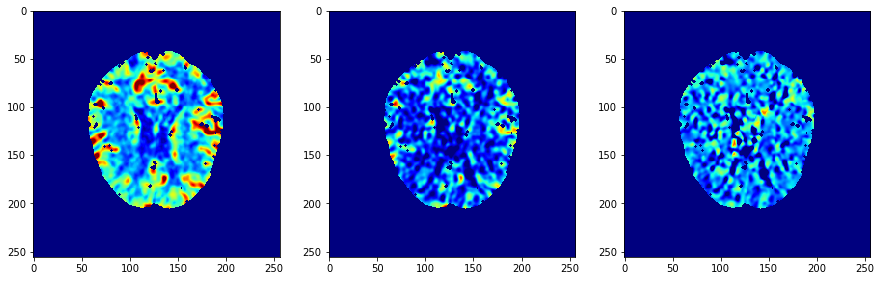

In [27]:
plt.figure(figsize=[15,5])
plt.subplot(131); plt.imshow(cbfGauss[7,...] * masks[2][7,...,0], 'jet', vmin=0, vmax=300)
plt.subplot(132); plt.imshow(cbvGauss[7,...] * masks[2][7,...,0], 'jet', vmin=0, vmax=5)
plt.subplot(133); plt.imshow(mttGauss[7,...] * masks[2][7,...,0], 'jet', vmin=0, vmax=2)

In [28]:
bc2 = BC.BiasCorrection(n2c[2], tacs[2], masks[2])
cbfN2c, cbvN2c, mttN2c = CalcParaMaps.CalcParaMaps(bc2, masks[2], vof = vofs[2], aif = aifs[2])
cbfN2c *= cbfFacs[2]
mttN2c /= cbfFacs[2]

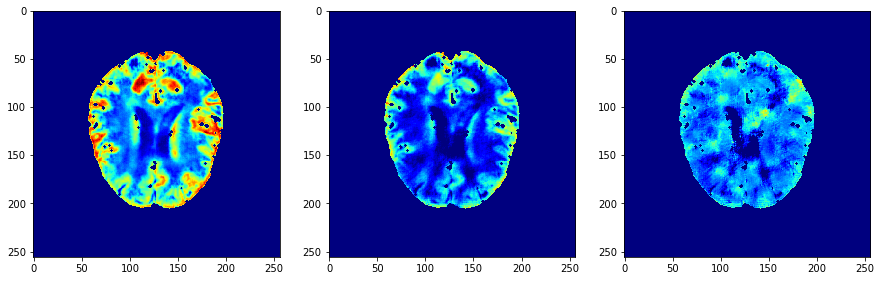

In [29]:
plt.figure(figsize=[15,5])
plt.subplot(131); plt.imshow(cbfN2c[7,...] * masks[2][7,...,0], 'jet', vmin=0, vmax=300)
plt.subplot(132); plt.imshow(cbvN2c[7,...] * masks[2][7,...,0], 'jet', vmin=0, vmax=5)
plt.subplot(133); plt.imshow(mttN2c[7,...] * masks[2][7,...,0], 'jet', vmin=0, vmax=2)